In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config; set_config(display='diagram')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics.pairwise import sigmoid_kernel, cosine_similarity, linear_kernel

from zytholic_project.base_model import BaseModel
from zytholic_project.evaluate import evaluate_proximity, content, test_prediction

In [134]:
dfbrew = pd.read_csv("../raw_data/Beers_Breweries_and_Beer Reviews/breweries.csv")
dfbeer = pd.read_csv("../raw_data/beers_style_renamed.csv")
dftop = pd.read_csv("../raw_data/top_beer_info_style_renamed.csv")

In [140]:
#read correspondance brewery
corres_xls = pd.read_csv('../assets/matching_brewery_names.csv')
corres_xls.set_index('bbr', inplace=True)
corres= corres_xls.to_dict()
#corres[0]

In [142]:
dfbrew = dfbrew.rename(columns={"name": "brewery"})
dfbrew = dfbrew.rename(columns={"id": "brewery_id"})

dfbrew['brewery'].replace(corres['top'], inplace=True)

dfbrewb =  pd.merge(dfbeer,dfbrew[['brewery_id','brewery']],how='left',on=['brewery_id'])

dftopbrew = pd.merge(dftop,dfbrewb[['name', 'brewery', 'state', 'country', 'retired']],
                     how='inner',on=['name','brewery'])

In [143]:
working_df = dftopbrew.drop(['description', 'key', 'style key'], axis= 1).drop_duplicates()
print(working_df.shape)
working_df = working_df[working_df.retired == 'f']
working_df.shape
#working_df['style'] = [st.split(' - ')[0] for st in working_df['style']]

working_df_train, working_df_test = train_test_split(working_df, test_size=0.2, stratify=working_df['style'])


(4377, 21)


In [ ]:
working_df.head()

# Pipeline

In [ ]:
tastes_features = working_df.select_dtypes(np.number).columns[2:]
tastes_features

pipe_style_country = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipe_abv_rating = make_pipeline(MinMaxScaler())
pipe_taste_features = make_pipeline(MinMaxScaler())
pipe_state = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=''),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

preprocess = make_column_transformer(
    (pipe_style_country, ['style', 
                          #'country'
                         ]),
    #(pipe_state, ['state']),
    (pipe_abv_rating, ['abv', 'ave rating']),
    (pipe_taste_features, tastes_features)
)

In [ ]:
preprocess

In [ ]:
preprocess.fit(X_train)
X_train_proc = preprocess.transform(X_train)
X_test_proc = preprocess.transform(X_test)

In [ ]:
X_train_proc.shape, X_test_proc.shape

# Inertia calculations

In [ ]:

inertias2 = []
for k in range(30, 100):
    res = KMeans(n_clusters=k)
    res.fit(X)
    inertias.append(res.inertia_)

In [ ]:
plt.plot(range(3, 100),inertias)

In [ ]:
inertias2 = []
for k in range(10, 30):
    res = KMeans(n_clusters=k)
    res.fit(X)
    inertias2.append(res.inertia_)

In [ ]:
plt.plot(range(10, 30),inertias2)

In [ ]:
cluster = KMeans(n_clusters=20)
cluster.fit(X)

In [ ]:
X_test['group'] = cluster.predict(y)

In [ ]:
X_test.group.value_counts()

# BaseModel Class usage

In [58]:
model = BaseModel()

model.get_data()

model.set_preprocess_pipeline()

model.process_data()


# compute sigmoid distance
sigmoid = sigmoid_kernel(
    model.X_train_proc,
    model.X_train_proc
)

#base_results = evaluate_proximity(model.X_train, sigmoid)

/Users/alix/.pyenv/versions/3.8.6/envs/zytholic_project/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [64]:
inertias2 = []
for k in range(155, 256, 5):
    res = model.fit(clusts= k)
    inertias2.append(res.kmeans_fit.inertia_)

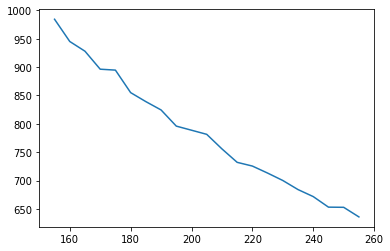

In [67]:
plt.plot(range(155, 256, 5), inertias2)

In [ ]:
base_results.plot.scatter(x='style', y='matching_percent')

In [ ]:
base_results.describe().T

In [ ]:
df.sample(10)

In [ ]:
final_style.sort_values('matching_percent', ascending=False).tail(20)

In [ ]:
final_style.sort_values('matching_percent', ascending=False).head(20)

In [ ]:
def reformat_styles(working_df, ohe=True):
    """
    Simplify the columns 'style' of an input DF
    Converts various features insides style name to OHE features
    """
    # specific columns to implement
    features_to_implement = ['milk', 'old', 'dark', 'wild', 'pale', 'red', 'imperial']

    # Get matching table for styles names and format it
    style_xls = pd.read_excel('../assets/style_convert.xlsx')
    style_xls.columns = style_xls.iloc[0, :]
    style_xls = style_xls.iloc[1:, 1:]


    # creation of a dictionary to replace automatically
    style_dict = style_xls.set_index('Converted').to_dict()
    style_dict = style_dict['Simplified']
    style_dict

    #styles_test = working_df[['style']].drop_duplicates()

    working_df['simple_style'] = working_df['style'].replace(style_dict)
    
    # One-Hot-Encoding of featrues_to_implement
    if ohe:
        for feat in features_to_implement:
            working_df[feat] = [1 if feat in elm.lower() else 0 for elm in working_df['style']]
        
    working_df.rename(columns={'style':'original_style', 'simple_style':'style'}, inplace=True)

    return working_df

# Evaluation of average recommended style

In [ ]:
reformated_df = reformat_styles(working_df)

preprocess.fit(reformated_df)

X_train = preprocess.transform(reformated_df)

sigmoid = sigmoid_kernel(X_train, X_train)

results = evaluate_proximity(working_df, sigmoid)

Results with fearture_to_impelement OHE + Simple style

In [ ]:
results.plot.scatter(x='style', y='matching_percent')

In [ ]:
results.describe().T

Results without fearture_to_impelement OHE + Simple style

In [ ]:
reformated_df = reformat_styles(working_df, ohe=False)

preprocess.fit(reformated_df)

X_train = preprocess.transform(reformated_df)

sigmoid = sigmoid_kernel(X_train, X_train)

results = evaluate_proximity(working_df, sigmoid)

In [ ]:
results.plot.scatter(x='style', y='matching_percent')

In [ ]:
results.describe().T

In [ ]:
results['style'].nunique()

Notes:
    
    10 beers in recommendations might be to hight
    try to reduce id to 5
    
    Also increase number of samples to test from

In [ ]:
reformated_df = working_df_train
preprocess.fit(reformated_df)
X_train = preprocess.transform(reformated_df)
sigmoid = sigmoid_kernel(X_train, X_train)

base_results = evaluate_proximity(working_df_train,  n_recomm=10, tests=30, sim_matrix=sigmoid)

In [ ]:
base_results.plot.scatter(x='style', y='matching_percent')

In [ ]:
base_results.describe().T

In [ ]:
base_results

In [ ]:
reformated_df = reformat_styles(working_df_train)
preprocess.fit(reformated_df)
X_train = preprocess.transform(reformated_df)
sigmoid = sigmoid_kernel(X_train, X_train)

results = evaluate_proximity(working_df_train,  n_recomm=5, tests=30, sim_matrix=sigmoid)

In [ ]:
results.plot.scatter(x='style', y='matching_percent')

In [ ]:
results.describe().T

In [ ]:
reformated_df = reformat_styles(working_df_train, ohe=False)
preprocess.fit(reformated_df)
X_train = preprocess.transform(reformated_df)
sigmoid = sigmoid_kernel(X_train, X_train)

results = evaluate_proximity(working_df_train,  n_recomm=5, tests=30, sim_matrix=sigmoid)

In [ ]:
results.plot.scatter(x='style', y='matching_percent')

In [ ]:
results.describe().T

In [68]:
X_train.shape

(3460, 55)

In [70]:
working_df_train

,name,original_style,brewery,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,...,wild,pale,red,imperial,original_style,original_style,original_style,original_style,original_style,style
2634,Mermaid Pilsner,Pilsner - German,Coney Island Brewing Company,5.2,3.61,25,40,27,38,8,...,0,0,0,0,Pilsner,Pilsner,Pilsner,Pilsner,Pilsner,Pilsner
4386,Stir Crazy,Winter Warmer,Indeed Brewing Company - Minneapolis,6.5,3.86,35,50,9,72,26,...,0,0,0,0,Winter Warmer,Winter Warmer,Winter Warmer,Winter Warmer,Winter Warmer,Winter Warmer
3121,Quinn's Amber Ale,Ale Red - Irish,Wachusett Brewing Company,4.8,3.37,20,30,10,35,8,...,0,0,1,0,Ale Red,Ale Red,Ale Red,Ale Red,Ale Red,Ale Red
1701,3 Best Friends,Lager Dark - European,Sudwerk Brewing Company,7.0,3.70,15,40,3,23,1,...,0,0,0,0,Lager,Lager,Lager,Lager,Lager,Lager
298,Mons Abbey Blonde,Ale Blonde - Belgian,Brasserie Belgh Brasse,7.0,3.75,15,30,20,39,26,...,0,0,0,0,Ale,Ale,Ale,Ale,Ale,Ale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,Coffee Baltic Porter,Porter Baltic,Crooked Stave Artisan Beer Project,8.5,4.10,25,45,11,95,13,...,0,0,0,0,Porter,Porter,Porter,Porter,Porter,Porter
3929,Confluence Ale,Ale Strong Pale - Belgian,Allagash Brewing Company,7.5,4.06,20,40,23,38,16,...,0,0,0,0,Ale Strong,Ale Strong,Ale Strong,Ale Strong,Ale Strong,Ale Strong
1686,Black Lager (Černé Pivo),Lager Dark - European,Notch Brewing,4.0,4.00,15,40,27,92,4,...,0,0,0,0,Lager,Lager,Lager,Lager,Lager,Lager
2791,Black Wych,Porter - English,Wychwood Brewery Company Ltd,5.0,3.72,20,30,15,54,5,...,0,0,0,0,Porter,Porter,Porter,Porter,Porter,Porter


# Comparison of similarity metrics

In [2]:
model = BaseModel()

model.get_data()

model.set_preprocess_pipeline()

model.process_data()

In [63]:
# compute sigmoid distance
sigmoid = sigmoid_kernel(
    model.X_train_proc,
    model.X_train_proc
)

sig_results = evaluate_proximity(model.X_train,  n_recomm=5, tests=30, sim_matrix=sigmoid)
sig_results.describe().T

,count,mean,std,min,25%,50%,75%,max
style,40.0,81.075000,89.967341,25.000000,29.750000,33.500000,121.0,506.0
matching_percent,40.0,96.960018,4.537725,81.481481,96.071429,99.333333,100.0,100.0


In [4]:
cosine = cosine_similarity(
    model.X_train_proc,
    model.X_train_proc
)

cosine_results = evaluate_proximity(model.X_train,  n_recomm=5, tests=30, sim_matrix=cosine)
cosine_results.describe().T

In [6]:
linear = linear_kernel(
    model.X_train_proc,
    model.X_train_proc
)

linear_results = evaluate_proximity(model.X_train,  n_recomm=5, tests=30, sim_matrix=linear)
linear_results.describe().T

IndexError: index 0 is out of bounds for axis 0 with size 0

# Predictions for beers in the test set

In [114]:
def test_prediction(model, n_recomm = 10):
    
    # Use the features to calculate kernel (calculate all distances at once?)
    sigmoid = cosine_similarity(model.X_test_proc, model.X_train_proc)

    matching_results = []
    substyles = []
    # Predict the closest beers in reference dataset
    for idx in range(sigmoid.shape[0]):
        distances = sigmoid[idx, :]
        sorted_distances = sorted(
                list(enumerate(distances)),
                key=lambda x:x[1],reverse=True)
        # get the top n predictions
        closest_items = sorted_distances[0:n_recomm+1]
        beers_indices = [i[0] for i in closest_items]
        
        # check original_style == predict_style percentage
        original_style = model.X_test["style"].iloc[idx]
        propositions = model.X_train.iloc[beers_indices, :]
        matching_percent = propositions[propositions['style'] == original_style].shape[0]\
            / propositions.shape[0] * 100
        matching_results.append(matching_percent)
        
        #compare substyle matching
        original_substyle = model.X_test.iloc[idx, -7:]
        comp = propositions.iloc[:, -7:]
        substyle_match = ((original_substyle == comp).sum()/ comp.shape[0]).min()
        substyles.append(substyle_match)
    
    results = model.X_test.copy()
    results['matching_percent'] = matching_results
    results['substyle'] = substyles
    return results

In [115]:
results = test_prediction(model)


results.groupby('style')[['matching_percent', 'substyle']].agg('describe')

In [94]:
a = model.X_train.iloc[0, -7:]

b = model.X_train.iloc[0:20, -7:]

In [103]:
((a == b).sum() / b.shape[0])

milk        1.00
old         1.00
dark        0.95
wild        1.00
pale        0.90
red         0.05
imperial    1.00
dtype: float64

In [133]:
results = test_prediction(model)


results.groupby('style')[['matching_percent', 'matching_substyle']].agg('describe')


matching_percent                            \
                                           count   mean  std    min    25%   
style                                                                        
Ale                                         73.0  100.0  0.0  100.0  100.0   
Ale Dark                                    50.0  100.0  0.0  100.0  100.0   
Ale Old                                     11.0  100.0  0.0  100.0  100.0   
Ale Pale                                    41.0  100.0  0.0  100.0  100.0   
Ale Red                                     32.0  100.0  0.0  100.0  100.0   
Ale Strong                                  41.0  100.0  0.0  100.0  100.0   
Altbier                                     11.0  100.0  0.0  100.0  100.0   
Barleywine                                  20.0  100.0  0.0  100.0  100.0   
Bitter                                      16.0  100.0  0.0  100.0  100.0   
Bière de Champagne / Bière Brut              9.0  100.0  0.0  100.0  100.0   
Bière de Garde                              11.0  100.0  0.0  100.0  100.0   
Bock                                        47.0  100.0  0.0  100.0  100.0   
Braggot                                     10.0  100.0  0.0  100.0  100.0   
Brett                                       11.0  100.0  0.0  100.0  100.0   
Dubbel                                      11.0  100.0  0.0  100.0  100.0   
Fruit and Field Beer                         9.0  100.0  0.0  100.0  100.0   
Happoshu                                    10.0  100.0  0.0  100.0  100.0   
Herb and Spice Beer                         10.0  100.0  0.0  100.0  100.0   
IPA                                         54.0  100.0  0.0  100.0  100.0   
Kvass                                        9.0  100.0  0.0  100.0  100.0   
Kölsch                                       9.0  100.0  0.0  100.0  100.0   
Lager                                      169.0  100.0  0.0  100.0  100.0   
Lambic                                      24.0  100.0  0.0  100.0  100.0   
Low Alcohol Beer                             8.0  100.0  0.0  100.0  100.0   
NEIPA                                       11.0  100.0  0.0  100.0  100.0   
Pilsner                                     31.0  100.0  0.0  100.0  100.0   
Porter                                      45.0  100.0  0.0  100.0  100.0   
Pumpkin Beer                                 9.0  100.0  0.0  100.0  100.0   
Quadrupel                                   10.0  100.0  0.0  100.0  100.0   
Rice                                         9.0  100.0  0.0  100.0  100.0   
Rye                                         21.0  100.0  0.0  100.0  100.0   
Sahti                                        9.0  100.0  0.0  100.0  100.0   
Saison                                      10.0  100.0  0.0  100.0  100.0   
Smoked                                      22.0  100.0  0.0  100.0  100.0   
Sour                                        41.0  100.0  0.0  100.0  100.0   
Steam Beer                                  11.0  100.0  0.0  100.0  100.0   
Stout                                       80.0  100.0  0.0  100.0  100.0   
Tripel                                      10.0  100.0  0.0  100.0  100.0   
Wheat                                       58.0  100.0  0.0  100.0  100.0   
Winter Warmer                                9.0  100.0  0.0  100.0  100.0   

                                                     matching_substyle         \
                                   50%    75%    max             count   mean   
style                                                                           
Ale                              100.0  100.0  100.0              73.0  100.0   
Ale Dark                         100.0  100.0  100.0              50.0  100.0   
Ale Old                          100.0  100.0  100.0              11.0  100.0   
Ale Pale                         100.0  100.0  100.0              41.0  100.0   
Ale Red                          100.0  100.0  100.0              32.0  100.0   
Ale Strong                   